# 자동차 번호판 디노이징 오토 인코더 실험


## import

In [1]:
# cuda gpu 설정 코드
import os
os.add_dll_directory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# cuda=11.2 cudnn=8.1.0 python=3.8 tensorflow-gpu=2.10.0
# !!!!! 오류 발생 시, 위 코드 삭제 후 실행 !!!!! ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# os 모듈 필요
# matplotlib 라이브러리 설치 : pip install matplotlib
# scikit-image(skimage) 라이브러리 설치 : pip install scikit-image
import os
import matplotlib.image as mpimg
from skimage import transform

### train data 읽기

In [2]:
train_dir = "data/latvian_car_plate/train/"

train_data = []
file_list = os.listdir(train_dir)

for img_name in file_list:
    img = mpimg.imread(train_dir + "/" + img_name) # png : 0~1 값으로 읽어들임
    img = transform.resize(img, (64, 320, 3))   # 크기 변환
    train_data.append(img)
        
x_train = np.array(train_data)

#x_train = x_train / 255.0

print(x_train.shape)

### test

(491, 64, 320, 3)


### train test split

In [3]:
x_train, x_test = train_test_split(x_train, test_size=0.3, random_state=42)

### noise 추가

In [4]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

#### noise 추가 이미지와 원본 이미지 비교

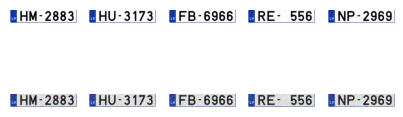

In [5]:
# 무작위로 추출해서 원본과 noisy 데이터 비교
random_index = np.random.randint(x_train.shape[0], size=5)

plt.figure(figsize=(7, 2))

for i, img_index in enumerate(random_index):
    plt.subplot(2, 7, i + 1)
    plt.imshow(x_train[img_index].reshape(64, 320, 3))
    plt.axis("off")

    plt.subplot(2, 7, 7 + i + 1)  # 바로 밑에 생성 이미지 표시
    plt.imshow(x_train_noisy[img_index].reshape(64, 320, 3))
    plt.axis("off")    

plt.show()

### 인코더 모델

In [6]:
encoder_input = keras.Input(shape=(64, 320, 3))
x = layers.Conv2D(16, kernel_size=3, padding="same", activation="relu")(encoder_input)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
encoder_output = layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
encoder_model = keras.Model(inputs=encoder_input, outputs=encoder_output)

In [7]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 320, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 320, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 160, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 160, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 80, 64)        18496 

### 디코더 모델

In [8]:
decoder_input = keras.Input(shape=(8, 40, 128))
x = layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(decoder_input)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, kernel_size=3, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")(x)
decoder_model = keras.Model(inputs=decoder_input, outputs=decoder_output)

In [9]:
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 40, 128)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 40, 128)        147584    
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 80, 128)      0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 80, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 32, 160, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 160, 32)       1846

### 오토 인코더 모델

In [10]:
inputs = encoder_model.inputs
x = encoder_model(inputs)
outputs = decoder_model(x)
autoencoder_model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 320, 3)]      0         
                                                                 
 model (Functional)          (None, 8, 40, 128)        97440     
                                                                 
 model_1 (Functional)        (None, 64, 320, 3)        244899    
                                                                 
Total params: 342,339
Trainable params: 342,339
Non-trainable params: 0
_________________________________________________________________


### 학습

In [12]:
autoencoder_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [13]:
history = autoencoder_model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=1000, batch_size=200)

Epoch 1/1000


2/2 [==============================] - 12s 5s/step - loss: 0.4163 - mae: 0.4163 - val_loss: 0.3801 - val_mae: 0.3801
Epoch 2/1000
2/2 [==============================] - 0s 251ms/step - loss: 0.3570 - mae: 0.3570 - val_loss: 0.2887 - val_mae: 0.2887
Epoch 3/1000
2/2 [==============================] - 0s 241ms/step - loss: 0.2903 - mae: 0.2903 - val_loss: 0.2958 - val_mae: 0.2958
Epoch 4/1000
2/2 [==============================] - 0s 257ms/step - loss: 0.2966 - mae: 0.2966 - val_loss: 0.2989 - val_mae: 0.2989
Epoch 5/1000
2/2 [==============================] - 0s 246ms/step - loss: 0.2991 - mae: 0.2991 - val_loss: 0.2996 - val_mae: 0.2996
Epoch 6/1000
2/2 [==============================] - 0s 241ms/step - loss: 0.2996 - mae: 0.2996 - val_loss: 0.2997 - val_mae: 0.2997
Epoch 7/1000
2/2 [==============================] - 0s 240ms/step - loss: 0.2998 - mae: 0.2998 - val_loss: 0.2998 - val_mae: 0.2998
Epoch 8/1000
2/2 [==============================] - 0s 238ms/step - loss: 0.2998 - mae: 0.2

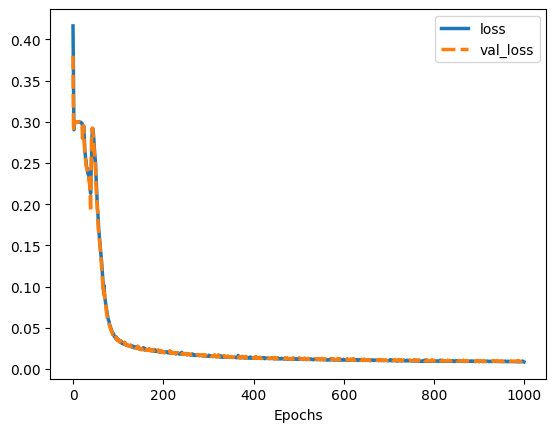

In [14]:
df_result = pd.DataFrame(history.history)
sns.lineplot(data=df_result[['loss', 'val_loss']], palette="tab10", linewidth=2.5)
plt.xlabel("Epochs")
plt.show()

### 별도 검증 데이터 (directory) 읽기

In [15]:
test_dir = "data/latvian_car_plate/test/"

test_data = []
file_list = os.listdir(test_dir)

for img_name in file_list:
    img = mpimg.imread(test_dir + "/" + img_name) # png : 0~1 값으로 읽어들임
    img = transform.resize(img, (64, 320, 3))   # 크기 변환
    test_data.append(img)
        
x_dir_test = np.array(test_data)

#x_dir_test = x_dir_test / 255.0

print(x_dir_test.shape)

(211, 64, 320, 3)


### 학습 모델 결과에 directory 검증 데이터 적용

In [16]:
ae_imgs = autoencoder_model.predict(x_dir_test)

7/7 [==============================] - 1s 68ms/step


### 디노이징 확인

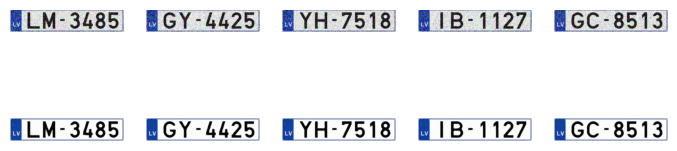

In [17]:
random_index = np.random.randint(x_dir_test.shape[0], size=5)

plt.figure(figsize=(12, 4))

for i, img_index in enumerate(random_index):
    plt.subplot(3, 7, 7 + i + 1)
    plt.imshow(x_dir_test[img_index].reshape(64, 320, 3))
    plt.axis("off")
    
    plt.subplot(3, 7, 14 + i + 1)  # 바로 밑에 생성 이미지 표시
    plt.imshow(ae_imgs[img_index].reshape(64, 320, 3))
    plt.axis("off")    

plt.show()